#### By: Peyman Shahidi
#### Created: Oct 9, 2025
#### Last Edit: Oct 16, 2025

<br>

In [98]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [99]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/taskcounts_aiexposure"

In [100]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [101]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop DWA columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,FT_Daily,FT_Hourly or more,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,46.67,5.26,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,25.27,4.81,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,35.11,3.73,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.47,6.38,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,7.87,0.65,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [102]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")
# Drop the first column
gpts_full_labels = gpts_full_labels.drop(gpts_full_labels.columns[:1], axis=1)

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,human_exposure_agg,gpt4_exposure,gpt4_exposure_alt_rubric,gpt_3_relevant,gpt4_automation,alpha,beta,gamma,automation,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E0,E2,E2,False,T2,0.00,0.50,1.00,0.50,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E0,E2,E0,False,T1,0.00,0.50,1.00,0.25,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2


In [103]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')
ONET

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 0


In [104]:
# Load the original ONET dataset to get DWA information back
ONET_with_DWAs = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET_with_DWAs = ONET_with_DWAs.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Merge with the full labelset to get exposure ratings
ONET_with_DWAs_labeled = ONET_with_DWAs.merge(
    gpts_full_labels, 
    on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], 
    how='left'
)

print(f"ONET dataset with DWAs and exposure labels: {len(ONET_with_DWAs_labeled):,} rows")
print(f"Rows with missing exposure labels: {ONET_with_DWAs_labeled['gpt4_exposure'].isna().sum():,}")

# Now analyze DWAs with multiple tasks
print("\n" + "="*80)
print("ANALYSIS: DWAs WITH MULTIPLE TASKS")
print("="*80)

# Group by DWA to count tasks per DWA
dwa_task_counts = ONET_with_DWAs_labeled.groupby(['DWA ID', 'DWA Title']).agg({
    'Task ID': 'nunique',  # Number of unique tasks per DWA
    'gpt4_exposure': 'nunique',  # Number of unique GPT-4 exposure ratings per DWA
    'human_labels': 'nunique'    # Number of unique human labels per DWA
}).reset_index()

# Rename columns for clarity
dwa_task_counts = dwa_task_counts.rename(columns={
    'Task ID': 'num_unique_tasks',
    'gpt4_exposure': 'num_unique_gpt4_ratings',
    'human_labels': 'num_unique_human_ratings'
})

# Filter for DWAs with more than one task
dwas_multiple_tasks = dwa_task_counts[dwa_task_counts['num_unique_tasks'] > 1].copy()

print(f"\nTotal number of unique DWAs: {len(dwa_task_counts):,}")
print(f"DWAs with multiple tasks: {len(dwas_multiple_tasks):,}")
print(f"Percentage of DWAs with multiple tasks: {len(dwas_multiple_tasks)/len(dwa_task_counts)*100:.1f}%")

# Sort by number of tasks (descending) to see DWAs with most tasks first
dwas_multiple_tasks = dwas_multiple_tasks.sort_values('num_unique_tasks', ascending=False)

print(f"\nTop 10 DWAs with most tasks:")
print(dwas_multiple_tasks.head(10).to_string(index=False))

# Summary statistics for DWAs with multiple tasks
print(f"\n" + "-"*50)
print("SUMMARY STATISTICS FOR DWAs WITH MULTIPLE TASKS:")
print("-"*50)

print(f"Number of tasks per DWA:")
print(f"  Min: {dwas_multiple_tasks['num_unique_tasks'].min()}")
print(f"  Max: {dwas_multiple_tasks['num_unique_tasks'].max()}")
print(f"  Mean: {dwas_multiple_tasks['num_unique_tasks'].mean():.2f}")
print(f"  Median: {dwas_multiple_tasks['num_unique_tasks'].median():.1f}")

print(f"\nNumber of unique GPT-4 ratings per DWA:")
print(f"  Min: {dwas_multiple_tasks['num_unique_gpt4_ratings'].min()}")
print(f"  Max: {dwas_multiple_tasks['num_unique_gpt4_ratings'].max()}")
print(f"  Mean: {dwas_multiple_tasks['num_unique_gpt4_ratings'].mean():.2f}")

print(f"\nNumber of unique Human ratings per DWA:")
print(f"  Min: {dwas_multiple_tasks['num_unique_human_ratings'].min()}")
print(f"  Max: {dwas_multiple_tasks['num_unique_human_ratings'].max()}")
print(f"  Mean: {dwas_multiple_tasks['num_unique_human_ratings'].mean():.2f}")

dwas_multiple_tasks

ONET dataset with DWAs and exposure labels: 22,310 rows
Rows with missing exposure labels: 0

ANALYSIS: DWAs WITH MULTIPLE TASKS

Total number of unique DWAs: 2,081
DWAs with multiple tasks: 2,052
Percentage of DWAs with multiple tasks: 98.6%

Top 10 DWAs with most tasks:
           DWA ID                                                     DWA Title  num_unique_tasks  num_unique_gpt4_ratings  num_unique_human_ratings
4.A.4.b.6.I07.D02                Advise students on academic or career matters.               120                        3                         3
4.A.3.b.6.I08.D03                        Record operational or production data.               109                        3                         3
4.A.2.a.1.I03.D04                                        Evaluate student work.               108                        3                         3
4.A.2.b.3.I01.D10                         Research topics in area of expertise.                74                        3         

,DWA ID,DWA Title,num_unique_tasks,num_unique_gpt4_ratings,num_unique_human_ratings
1977,4.A.4.b.6.I07.D02,Advise students on academic or career matters.,120,3,3
1407,4.A.3.b.6.I08.D03,Record operational or production data.,109,3,3
372,4.A.2.a.1.I03.D04,Evaluate student work.,108,3,3
749,4.A.2.b.3.I01.D10,Research topics in area of expertise.,74,3,3
1449,4.A.3.b.6.I11.D04,Record patient medical histories.,69,3,3
...,...,...,...,...,...
1596,4.A.4.a.3.I02.D02,Present sustainable products or services infor...,2,2,1
810,4.A.2.b.6.I02.D05,Adjust routes or speeds as necessary.,2,1,1
537,4.A.2.b.1.I03.D01,Authorize construction activities.,2,1,2
124,4.A.1.a.2.I02.D01,Monitor industrial energy consumption or manag...,2,1,2


In [105]:
# Detailed analysis of exposure rating distributions
print("\n" + "="*80)
print("DETAILED EXPOSURE RATING ANALYSIS")
print("="*80)

# Count how many DWAs have different numbers of unique ratings
print("\nDistribution of unique GPT-4 exposure ratings per DWA:")
gpt4_dist = dwas_multiple_tasks['num_unique_gpt4_ratings'].value_counts().sort_index()
for rating_count, num_dwas in gpt4_dist.items():
    percentage = (num_dwas / len(dwas_multiple_tasks)) * 100
    print(f"  {rating_count} unique rating(s): {num_dwas:,} DWAs ({percentage:.1f}%)")

print("\nDistribution of unique Human exposure ratings per DWA:")
human_dist = dwas_multiple_tasks['num_unique_human_ratings'].value_counts().sort_index()
for rating_count, num_dwas in human_dist.items():
    percentage = (num_dwas / len(dwas_multiple_tasks)) * 100
    print(f"  {rating_count} unique rating(s): {num_dwas:,} DWAs ({percentage:.1f}%)")

# Let's look at specific examples of DWAs with varying exposure ratings
print("\n" + "-"*60)
print("EXAMPLES OF DWAs WITH DIFFERENT EXPOSURE PATTERNS:")
print("-"*60)

# Example 1: DWA with 1 unique GPT-4 rating but multiple tasks
example_1_uniform = dwas_multiple_tasks[dwas_multiple_tasks['num_unique_gpt4_ratings'] == 1].iloc[0]
dwa_id_1 = example_1_uniform['DWA ID']
print(f"\nExample 1 - Uniform exposure (1 unique GPT-4 rating):")
print(f"DWA: {example_1_uniform['DWA Title']} ({dwa_id_1})")
print(f"Number of tasks: {example_1_uniform['num_unique_tasks']}")

# Show the tasks and their ratings for this DWA
example_1_details = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id_1][
    ['Task Title', 'gpt4_exposure', 'human_labels']
].drop_duplicates()
print(f"Sample tasks and ratings:")
print(example_1_details.head().to_string(index=False))

# Example 2: DWA with 3 unique GPT-4 ratings
example_2_varied = dwas_multiple_tasks[dwas_multiple_tasks['num_unique_gpt4_ratings'] == 3].iloc[0]
dwa_id_2 = example_2_varied['DWA ID']
print(f"\nExample 2 - Varied exposure (3 unique GPT-4 ratings):")
print(f"DWA: {example_2_varied['DWA Title']} ({dwa_id_2})")
print(f"Number of tasks: {example_2_varied['num_unique_tasks']}")

# Show the exposure distribution for this DWA
example_2_details = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id_2]
gpt4_counts = example_2_details['gpt4_exposure'].value_counts()
human_counts = example_2_details['human_labels'].value_counts()

print(f"GPT-4 exposure distribution:")
for rating, count in gpt4_counts.items():
    print(f"  {rating}: {count} tasks")

print(f"Human exposure distribution:")
for rating, count in human_counts.items():
    print(f"  {rating}: {count} tasks")

# Show some sample tasks with different ratings
print(f"Sample tasks with different ratings:")
sample_tasks = example_2_details[['Task Title', 'gpt4_exposure', 'human_labels']].drop_duplicates()
print(sample_tasks.head(10).to_string(index=False))


DETAILED EXPOSURE RATING ANALYSIS

Distribution of unique GPT-4 exposure ratings per DWA:
  1 unique rating(s): 830 DWAs (40.4%)
  2 unique rating(s): 905 DWAs (44.1%)
  3 unique rating(s): 317 DWAs (15.4%)

Distribution of unique Human exposure ratings per DWA:
  1 unique rating(s): 1,059 DWAs (51.6%)
  2 unique rating(s): 716 DWAs (34.9%)
  3 unique rating(s): 277 DWAs (13.5%)

------------------------------------------------------------
EXAMPLES OF DWAs WITH DIFFERENT EXPOSURE PATTERNS:
------------------------------------------------------------

Example 1 - Uniform exposure (1 unique GPT-4 rating):
DWA: Clean production equipment. (4.A.3.a.1.I03.D21)
Number of tasks: 66
Sample tasks and ratings:
                                                                                                               Task Title gpt4_exposure human_labels
                                                                Inspect, clean, and assemble molds before beginning work.            E0     

In [106]:
# Analysis of implications for exposure measurement
print("\n" + "="*80)
print("IMPLICATIONS FOR EXPOSURE MEASUREMENT")
print("="*80)

# Calculate how task-level vs DWA-level aggregation would differ
print("\nComparison of aggregation approaches:")
print("-" * 40)

# For DWAs with multiple exposure ratings, see how different aggregation methods compare
mixed_exposure_dwas = dwas_multiple_tasks[
    (dwas_multiple_tasks['num_unique_gpt4_ratings'] > 1) | 
    (dwas_multiple_tasks['num_unique_human_ratings'] > 1)
].copy()

print(f"DWAs with mixed exposure ratings: {len(mixed_exposure_dwas):,}")
print(f"Percentage of multi-task DWAs with mixed ratings: {len(mixed_exposure_dwas)/len(dwas_multiple_tasks)*100:.1f}%")

# Let's calculate different exposure measures for a few example DWAs
print(f"\nExample calculations for DWAs with mixed ratings:")
print("-" * 50)

# Take the top 3 DWAs with most tasks and mixed ratings
example_dwas = mixed_exposure_dwas.head(3)

for idx, dwa_info in example_dwas.iterrows():
    dwa_id = dwa_info['DWA ID']
    dwa_title = dwa_info['DWA Title']
    
    # Get all tasks for this DWA
    dwa_tasks = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id].copy()
    
    # Calculate task-level exposure metrics
    dwa_tasks["task_weight"] = dwa_tasks["Task Type"].map({"Core": 1.0, "Supplemental": 0.5}).fillna(1.0)
    
    # GPT-4 metrics
    dwa_tasks["gpt4_E1"] = (dwa_tasks["gpt4_exposure"] == "E1").astype(int)
    dwa_tasks["gpt4_E2"] = (dwa_tasks["gpt4_exposure"] == "E2").astype(int)
    
    gpt4_alpha = (dwa_tasks["gpt4_E1"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    gpt4_beta = gpt4_alpha + 0.5 * (dwa_tasks["gpt4_E2"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    
    # Human metrics
    dwa_tasks["human_E1"] = (dwa_tasks["human_labels"] == "E1").astype(int)
    dwa_tasks["human_E2"] = (dwa_tasks["human_labels"] == "E2").astype(int)
    
    human_alpha = (dwa_tasks["human_E1"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    human_beta = human_alpha + 0.5 * (dwa_tasks["human_E2"] * dwa_tasks["task_weight"]).sum() / dwa_tasks["task_weight"].sum()
    
    print(f"\nDWA: {dwa_title[:60]}...")
    print(f"  Tasks: {len(dwa_tasks)} | GPT-4 ratings: {dwa_info['num_unique_gpt4_ratings']} | Human ratings: {dwa_info['num_unique_human_ratings']}")
    print(f"  GPT-4 Alpha: {gpt4_alpha:.3f} | GPT-4 Beta: {gpt4_beta:.3f}")
    print(f"  Human Alpha: {human_alpha:.3f} | Human Beta: {human_beta:.3f}")
    
    # Show rating distribution
    gpt4_dist = dwa_tasks['gpt4_exposure'].value_counts().sort_index()
    human_dist = dwa_tasks['human_labels'].value_counts().sort_index()
    print(f"  GPT-4 distribution: {dict(gpt4_dist)}")
    print(f"  Human distribution: {dict(human_dist)}")

# Summary of key findings
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"✓ 98.6% of DWAs ({2052:,} out of {2081:,}) have multiple tasks associated with them")
print(f"✓ Among DWAs with multiple tasks:")
print(f"  - 59.6% have mixed GPT-4 exposure ratings (2 or 3 different ratings)")
print(f"  - 48.4% have mixed human exposure ratings (2 or 3 different ratings)")
print(f"✓ Maximum exposure diversity: 3 different rating levels per DWA")
print(f"✓ This variation within DWAs suggests that task-level analysis provides")
print(f"  more granular and potentially more accurate exposure measurements")
print(f"✓ DWA-level aggregation would smooth over important within-DWA variation")


IMPLICATIONS FOR EXPOSURE MEASUREMENT

Comparison of aggregation approaches:
----------------------------------------
DWAs with mixed exposure ratings: 1,413
Percentage of multi-task DWAs with mixed ratings: 68.9%

Example calculations for DWAs with mixed ratings:
--------------------------------------------------

DWA: Advise students on academic or career matters....
  Tasks: 120 | GPT-4 ratings: 3 | Human ratings: 3
  GPT-4 Alpha: 0.028 | GPT-4 Beta: 0.223
  Human Alpha: 0.127 | Human Beta: 0.469
  GPT-4 distribution: {'E0': np.int64(74), 'E1': np.int64(3), 'E2': np.int64(43)}
  Human distribution: {'E0': np.int64(29), 'E1': np.int64(17), 'E2': np.int64(74)}

DWA: Record operational or production data....
  Tasks: 109 | GPT-4 ratings: 3 | Human ratings: 3
  GPT-4 Alpha: 0.720 | GPT-4 Beta: 0.788
  Human Alpha: 0.021 | Human Beta: 0.476
  GPT-4 distribution: {'E0': np.int64(15), 'E1': np.int64(78), 'E2': np.int64(16)}
  Human distribution: {'E0': np.int64(7), 'E1': np.int64(2), 'E2'

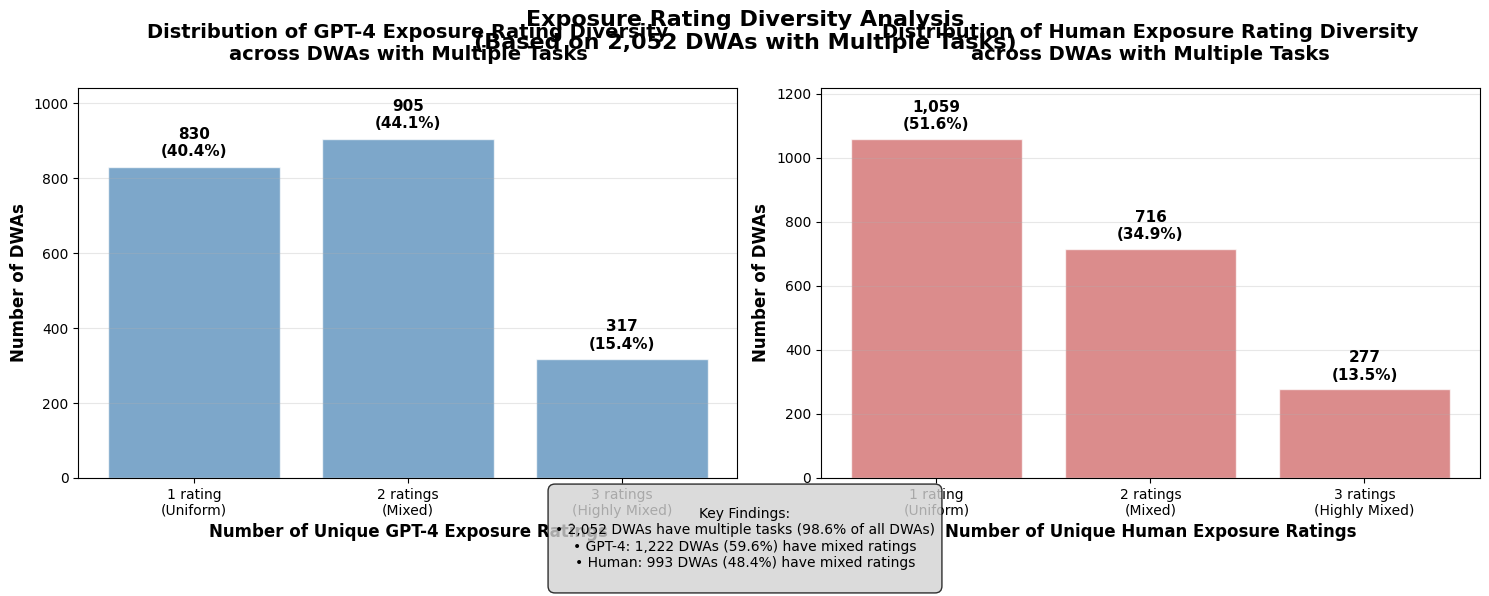

✓ Histograms showing DWA exposure rating diversity saved and displayed


In [107]:
# Create histograms showing distribution of unique exposure ratings per DWA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# GPT-4 exposure histogram
gpt4_counts = dwas_multiple_tasks['num_unique_gpt4_ratings'].value_counts().sort_index()
bars1 = ax1.bar(gpt4_counts.index, gpt4_counts.values, color='steelblue', alpha=0.7, edgecolor='white', linewidth=1)

# Add percentage labels on bars
total_dwas = len(dwas_multiple_tasks)
for bar, count in zip(bars1, gpt4_counts.values):
    percentage = (count / total_dwas) * 100
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_xlabel('Number of Unique GPT-4 Exposure Ratings', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of DWAs', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of GPT-4 Exposure Rating Diversity\nacross DWAs with Multiple Tasks', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['1 rating\n(Uniform)', '2 ratings\n(Mixed)', '3 ratings\n(Highly Mixed)'])
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(gpt4_counts.values) * 1.15)

# Human exposure histogram
human_counts = dwas_multiple_tasks['num_unique_human_ratings'].value_counts().sort_index()
bars2 = ax2.bar(human_counts.index, human_counts.values, color='indianred', alpha=0.7, edgecolor='white', linewidth=1)

# Add percentage labels on bars
for bar, count in zip(bars2, human_counts.values):
    percentage = (count / total_dwas) * 100
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax2.set_xlabel('Number of Unique Human Exposure Ratings', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of DWAs', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Human Exposure Rating Diversity\nacross DWAs with Multiple Tasks', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['1 rating\n(Uniform)', '2 ratings\n(Mixed)', '3 ratings\n(Highly Mixed)'])
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, max(human_counts.values) * 1.15)

# Add overall statistics as text
fig.suptitle(f'Exposure Rating Diversity Analysis\n(Based on {total_dwas:,} DWAs with Multiple Tasks)', 
             fontsize=16, fontweight='bold', y=0.98)

# Add summary statistics
summary_text = f"""
Key Findings:
• {total_dwas:,} DWAs have multiple tasks (98.6% of all DWAs)
• GPT-4: {gpt4_counts[2] + gpt4_counts[3]:,} DWAs ({((gpt4_counts[2] + gpt4_counts[3]) / total_dwas * 100):.1f}%) have mixed ratings
• Human: {human_counts[2] + human_counts[3]:,} DWAs ({((human_counts[2] + human_counts[3]) / total_dwas * 100):.1f}%) have mixed ratings
"""

plt.figtext(0.5, 0.02, summary_text, ha='center', va='bottom', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.20)

# Save the plot
plt.savefig(f'{output_plot_path}/dwa_exposure_diversity_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Histograms showing DWA exposure rating diversity saved and displayed")

In [108]:
# Create datasets of DWAs that appear in multiple occupation groups using canonical ONET columns, with merged AI exposure measures
print('\n' + '='*80)
print('DWAs WITH MULTIPLE REPETITIONS ACROSS ONET HIERARCHY (CANONICAL COLUMNS, WITH AI EXPOSURE MEASURES)')
print('='*80)

# Required columns (as used elsewhere in the notebook)
required_cols = [
    'DWA ID', 'DWA Title',
    'Major_Group_Code', 'Major_Group_Title',
    'Minor_Group_Code', 'Minor_Group_Title',
    'Broad_Occupation_Code', 'Broad_Occupation_Title',
    'Detailed_Occupation_Code', 'Detailed_Occupation_Title',
    'O*NET-SOC Code', 'Occupation Title',
    'Task ID', 'Task Title', 'Task Type'
# add exposure columns for merge
    'gpt4_exposure', 'human_labels'
 ]

# Merge gpts_full_labels with ONET_with_DWAs to get exposure measures before subgroup analysis
if 'ONET_with_DWAs' not in globals():
    print("ONET_with_DWAs DataFrame not found in the notebook environment.")
    print("Please run the earlier cells that load ONET_with_DWAs, then re-run this cell.")
elif 'gpts_full_labels' not in globals():
    print("gpts_full_labels DataFrame not found. Please run the cell that loads it.")
else:
    ONET_with_DWAs_labeled_group = ONET_with_DWAs.merge(
        gpts_full_labels,
        on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'],
        how='left'
    )

    missing = [c for c in required_cols if c not in ONET_with_DWAs_labeled_group.columns]
    if len(missing) > 0:
        print('Warning: the following canonical ONET columns are missing and will be skipped:')
        print(missing)

    # Build a minimal DWA <-> occupation mapping using canonical columns
    available_cols = [c for c in required_cols if c in ONET_with_DWAs_labeled_group.columns]
    # Select the canonical mapping columns plus DWA identifiers
    select_cols = ['DWA ID', 'DWA Title'] + [c for c in available_cols if c not in ('DWA ID', 'DWA Title')]

    dwa_onet_map = ONET_with_DWAs_labeled_group[select_cols].drop_duplicates().copy()

    # Compute total task counts per DWA for context
    if 'Task Title' in ONET_with_DWAs_labeled_group.columns:
        dwa_task_counts = ONET_with_DWAs_labeled_group.groupby('DWA ID').agg(total_tasks=('Task Title', 'count')).reset_index()
    else:
        # fallback to counting rows per DWA
        dwa_task_counts = ONET_with_DWAs_labeled_group.groupby('DWA ID').size().reset_index(name='total_tasks')

    # Helper to join unique values into a clean string
    import pandas as _pd

    def _join_unique(series):
        vals = [str(x) for x in _pd.unique(series.dropna())]
        return '; '.join(sorted(vals)) if len(vals) > 0 else ''

    # Define levels using canonical columns (code_col, title_col, human-readable level name, output key)
    levels = [
        ('Major_Group_Code', 'Major_Group_Title', 'Major Group', 'major_groups'),
        ('Minor_Group_Code', 'Minor_Group_Title', 'Minor Group', 'minor_groups'),
        ('Broad_Occupation_Code', 'Broad_Occupation_Title', 'Broad Occupation', 'broad_occupations'),
        ('Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Detailed Occupation', 'detailed_occupations'),
        ('O*NET-SOC Code', 'Occupation Title', 'O*NET-SOC Code', 'onet_soc_codes')
    ]

    datasets_canonical = {}
    summary = []

    for code_col, title_col, lvl_name, key in levels:
        if code_col not in dwa_onet_map.columns:
            print(f"Skipping {lvl_name} (column {code_col} not found)")
            continue

        # Aggregate by DWA and count unique codes/titles and exposure measures
        agg_dict = {
            'num_unique_codes': (code_col, lambda s: s.dropna().nunique()),
            'codes': (code_col, _join_unique),
            'titles': (title_col, _join_unique) if title_col in dwa_onet_map.columns else (_pd.NamedAgg(column=code_col, aggfunc=lambda s: _join_unique(s))),
        }
        # Add exposure aggregation
        if 'gpt4_exposure' in dwa_onet_map.columns:
            agg_dict['gpt4_exposures'] = ('gpt4_exposure', _join_unique)
        if 'human_labels' in dwa_onet_map.columns:
            agg_dict['human_labels'] = ('human_labels', _join_unique)

        agg_df = dwa_onet_map.groupby(['DWA ID', 'DWA Title']).agg(**agg_dict).reset_index()

        # Merge task counts
        agg_df = agg_df.merge(dwa_task_counts, left_on='DWA ID', right_on='DWA ID', how='left')

        # Filter DWAs that appear in more than one unique code at this level
        multiple_df = agg_df[agg_df['num_unique_codes'] > 1].copy()

        # Sort for inspection
        multiple_df = multiple_df.sort_values('num_unique_codes', ascending=False).reset_index(drop=True)

        # Prepare output folder
        output_folder = os.path.join(output_data_path, 'DWA_analysis')
        os.makedirs(output_folder, exist_ok=True)
        # Save
        datasets_canonical[key] = multiple_df
        multiple_df.to_csv(f'{output_folder}/repetitiveDWA_{key}.csv', index=False)

        print(f"Saved: {len(multiple_df):,} DWAs appearing in multiple {lvl_name} to {output_folder}/repetitiveDWA_{key}.csv")
        summary.append({'Level': lvl_name, 'DWA_count': len(multiple_df)})

    # Save summary table
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(f'{output_folder}/repetitiveDWA_summary.csv', index=False)
    print('\nSummary:')
    print(summary_df.to_string(index=False))

    # Keep for later inspection
    canonical_dwa_datasets = datasets_canonical
    print('\nCreated canonical ONET-based DWA datasets with AI exposure measures and saved to output folder')


DWAs WITH MULTIPLE REPETITIONS ACROSS ONET HIERARCHY (CANONICAL COLUMNS, WITH AI EXPOSURE MEASURES)
['Task Typegpt4_exposure']
Saved: 711 DWAs appearing in multiple Major Group to ../data/computed_objects/DWA_analysis/repetitiveDWA_major_groups.csv
Saved: 711 DWAs appearing in multiple Major Group to ../data/computed_objects/DWA_analysis/repetitiveDWA_major_groups.csv
Saved: 1,770 DWAs appearing in multiple Minor Group to ../data/computed_objects/DWA_analysis/repetitiveDWA_minor_groups.csv
Saved: 1,770 DWAs appearing in multiple Minor Group to ../data/computed_objects/DWA_analysis/repetitiveDWA_minor_groups.csv
Saved: 1,944 DWAs appearing in multiple Broad Occupation to ../data/computed_objects/DWA_analysis/repetitiveDWA_broad_occupations.csv
Saved: 1,944 DWAs appearing in multiple Broad Occupation to ../data/computed_objects/DWA_analysis/repetitiveDWA_broad_occupations.csv
Saved: 1,997 DWAs appearing in multiple Detailed Occupation to ../data/computed_objects/DWA_analysis/repetitiveD

In [109]:
# Create a long-format dataset of all DWA-task-occupation rows, with repetition counts per hierarchy level and exposure columns, with custom column order
import os
import re
print('\n' + '='*80)
print('LONG-FORM DWA-TASK-OCCUPATION DATASET WITH REPETITION COUNTS AND EXPOSURE LABELS (CUSTOM COLUMN ORDER)')
print('='*80)

# Ensure ONET_with_DWAs_labeled is present
if 'ONET_with_DWAs_labeled' not in globals():
    print("ONET_with_DWAs_labeled DataFrame not found. Please run earlier cells.")
else:
    # Define canonical columns
    hierarchy_cols = [
        ('Major_Group_Code', 'Major_Group_Title'),
        ('Minor_Group_Code', 'Minor_Group_Title'),
        ('Broad_Occupation_Code', 'Broad_Occupation_Title'),
        ('Detailed_Occupation_Code', 'Detailed_Occupation_Title'),
        ('O*NET-SOC Code', 'Occupation Title')
    ]
    # Desired column order for output
    ordered_cols = [
        'DWA ID',
        'DWA Title',
        'gpt4_exposure',
        'human_labels',
        'Task Title',
        'Task ID',
        'Occupation Title',
        'O*NET-SOC Code'
    ]
    # Add all hierarchy columns
    all_cols = ordered_cols + [c for pair in hierarchy_cols for c in pair if c not in ordered_cols and c in ONET_with_DWAs_labeled.columns]
    # Ensure unique column list (preserve order)
    seen = set()
    all_cols_unique = []
    for c in all_cols:
        if c not in seen:
            all_cols_unique.append(c)
            seen.add(c)
    # Add any remaining columns (e.g., repetition columns, etc.)
    remaining_cols = [c for c in ONET_with_DWAs_labeled.columns if c not in all_cols_unique]
    all_cols_unique += remaining_cols
    long_df = ONET_with_DWAs_labeled[all_cols_unique].copy()

    # Helper to sanitize repetition column names (safe for pandas)
    def _safe_col_name(col):
        return re.sub(r'[^0-9a-zA-Z]+', '_', col).strip('_')

    # For each DWA, compute repetition counts at each hierarchy level
    rep_cols = []
    for code_col, title_col in hierarchy_cols:
        safe_name = _safe_col_name(code_col)
        rep_col_name = f'repetitions_{safe_name}'
        rep_cols.append(rep_col_name)

        if code_col in long_df.columns:
            # Ensure selecting the column yields a Series
            series = long_df[code_col]
            # Compute nunique per DWA
            rep_count_series = long_df.groupby('DWA ID')[code_col].transform(lambda s: s.dropna().nunique())
            # If the transform returns a DataFrame accidentally, take first column
            if hasattr(rep_count_series, 'ndim') and rep_count_series.ndim > 1:
                rep_count_series = rep_count_series.iloc[:, 0]
            long_df[rep_col_name] = rep_count_series.values
        else:
            long_df[rep_col_name] = 0

    # Compute the maximum repetition count across all levels for each row
    long_df['max_repetitions'] = long_df[rep_cols].max(axis=1)

    # Sort by max_repetitions descending
    long_df = long_df.sort_values('max_repetitions', ascending=False).reset_index(drop=True)

    # Prepare output file
    output_file = os.path.join(output_folder, 'repetitiveDWA_long.csv')

    # Save to CSV
    long_df.to_csv(output_file, index=False)
    print(f"✓ Saved long-format DWA dataset to: {output_file}")
    print(f"Total rows: {len(long_df):,}")


LONG-FORM DWA-TASK-OCCUPATION DATASET WITH REPETITION COUNTS AND EXPOSURE LABELS (CUSTOM COLUMN ORDER)
✓ Saved long-format DWA dataset to: ../data/computed_objects/DWA_analysis/repetitiveDWA_long.csv
Total rows: 22,310
✓ Saved long-format DWA dataset to: ../data/computed_objects/DWA_analysis/repetitiveDWA_long.csv
Total rows: 22,310


# DWA-Level Analysis

Now we proceed with DWA-level analysis, where we assign each DWA the exposure rating that has the highest fraction within that DWA.

# Task Time vs AI Exposure Analysis

Scatter plots showing the relationship between task time allocation (Task_Time_Percentage) and AI exposure measures.

In [ ]:
# Create weighted exposure measures at the occupation level
# Each task gets a weight based on its exposure rating: E0=0, E1=10, E2=5
# Then multiply by task time percentage to get exposure-weighted time allocation

# Ensure we have the dataset with task time measures and exposure data
if 'Task_Time_Percentage' not in ONET.columns:
    print("Loading dataset with task time measures...")
    # Load the dataset with task time measures
    ONET_with_time = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks_with_time_measures.csv')
    
    # Merge with exposure labels
    ONET_with_time = ONET_with_time.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)
    ONET_plot = ONET_with_time.merge(
        gpts_full_labels, 
        on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], 
        how='left'
    )
else:
    ONET_plot = ONET.copy()

# Filter to tasks with valid exposure ratings and time measures
ONET_plot = ONET_plot.dropna(subset=['gpt4_exposure', 'human_labels', 'Task_Time_Percentage'])

print(f"Dataset for analysis: {len(ONET_plot):,} tasks with valid exposure and time data")

# Create exposure weights: E0=0, E1=1, E2=0.5
def get_exposure_weight(exposure_rating):
    if exposure_rating == 'E0':
        return 0
    elif exposure_rating == 'E1':
        return 1
    elif exposure_rating == 'E2':
        return 0.5
    else:
        return 0

# Apply exposure weights
ONET_plot['gpt4_weight'] = ONET_plot['gpt4_exposure'].apply(get_exposure_weight)
ONET_plot['human_weight'] = ONET_plot['human_labels'].apply(get_exposure_weight)

# Calculate weighted exposure measures at occupation level
# Multiply task time percentage by exposure weight
ONET_plot['gpt4_weighted_time'] = ONET_plot['Task_Time_Percentage'] * ONET_plot['gpt4_weight']
ONET_plot['human_weighted_time'] = ONET_plot['Task_Time_Percentage'] * ONET_plot['human_weight']

# Aggregate at occupation level
occupation_exposure = ONET_plot.groupby(['O*NET-SOC Code', 'Occupation Title']).agg({
    'gpt4_weighted_time': 'sum',    # Sum of (time_percentage × exposure_weight)
    'human_weighted_time': 'sum',   # Sum of (time_percentage × exposure_weight)
    'Task_Time_Percentage': 'sum',  # Should sum to 100% for validation
    'Task ID': 'count'              # Number of tasks per occupation
}).reset_index()

occupation_exposure.columns = ['O*NET-SOC Code', 'Occupation Title', 'GPT4_Weighted_Exposure', 
                              'Human_Weighted_Exposure', 'Total_Time_Check', 'Number_of_Tasks']

print(f"\nOccupation-level exposure measures calculated for {len(occupation_exposure):,} occupations")
print(f"Average tasks per occupation: {occupation_exposure['Number_of_Tasks'].mean():.1f}")

# Validation: Check that time percentages sum to ~100%
print(f"\nValidation - Total time percentage per occupation:")
print(f"  Min: {occupation_exposure['Total_Time_Check'].min():.1f}%")
print(f"  Max: {occupation_exposure['Total_Time_Check'].max():.1f}%") 
print(f"  Mean: {occupation_exposure['Total_Time_Check'].mean():.1f}%")

print(f"\nWeighted Exposure Measures:")
print(f"GPT-4 Weighted Exposure:")
print(f"  Min: {occupation_exposure['GPT4_Weighted_Exposure'].min():.1f}")
print(f"  Max: {occupation_exposure['GPT4_Weighted_Exposure'].max():.1f}")
print(f"  Mean: {occupation_exposure['GPT4_Weighted_Exposure'].mean():.1f}")

print(f"\nHuman Weighted Exposure:")
print(f"  Min: {occupation_exposure['Human_Weighted_Exposure'].min():.1f}")
print(f"  Max: {occupation_exposure['Human_Weighted_Exposure'].max():.1f}")
print(f"  Mean: {occupation_exposure['Human_Weighted_Exposure'].mean():.1f}")

# Show example calculations
print(f"\nExample - Top 10 occupations by GPT-4 weighted exposure:")
top_gpt4 = occupation_exposure.nlargest(10, 'GPT4_Weighted_Exposure')
print(top_gpt4[['Occupation Title', 'GPT4_Weighted_Exposure', 'Human_Weighted_Exposure', 'Number_of_Tasks']].to_string(index=False))

occupation_exposure.head()

In [ ]:
# Create visualizations for weighted exposure measures
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Occupation-Level Weighted AI Exposure Analysis\n(Time-Weighted by Exposure: E0=0, E1=1, E2=0.5)', fontsize=16, fontweight='bold', y=0.98)

# 1. Top 20 occupations by GPT-4 weighted exposure
ax1 = axes[0, 0]
top_20_gpt4 = occupation_exposure.nlargest(20, 'GPT4_Weighted_Exposure')
y_pos = np.arange(len(top_20_gpt4))

# Truncate long occupation titles
titles_truncated_gpt4 = [title[:35] + '...' if len(title) > 35 else title 
                        for title in top_20_gpt4['Occupation Title']]

bars = ax1.barh(y_pos, top_20_gpt4['GPT4_Weighted_Exposure'], 
                alpha=0.7, color='#1f77b4', edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(titles_truncated_gpt4, fontsize=9)
ax1.set_xlabel('GPT-4 Weighted Exposure Score')
ax1.set_title('Top 20 Occupations by GPT-4 Exposure')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Top 20 occupations by Human weighted exposure  
ax2 = axes[0, 1]
top_20_human = occupation_exposure.nlargest(20, 'Human_Weighted_Exposure')
y_pos = np.arange(len(top_20_human))

# Truncate long occupation titles
titles_truncated_human = [title[:35] + '...' if len(title) > 35 else title 
                         for title in top_20_human['Occupation Title']]

bars = ax2.barh(y_pos, top_20_human['Human_Weighted_Exposure'], 
                alpha=0.7, color='#ff7f0e', edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(titles_truncated_human, fontsize=9)
ax2.set_xlabel('Human Weighted Exposure Score')
ax2.set_title('Top 20 Occupations by Human Exposure')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# 3. Distribution of GPT-4 weighted exposure
ax3 = axes[1, 0]
ax3.hist(occupation_exposure['GPT4_Weighted_Exposure'], bins=30, alpha=0.7, color='#1f77b4', edgecolor='black')
ax3.set_xlabel('GPT-4 Weighted Exposure Score')
ax3.set_ylabel('Number of Occupations')
ax3.set_title('Distribution of GPT-4 Weighted Exposure')
ax3.grid(True, alpha=0.3)

# 4. Distribution of Human weighted exposure
ax4 = axes[1, 1]
ax4.hist(occupation_exposure['Human_Weighted_Exposure'], bins=30, alpha=0.7, color='#ff7f0e', edgecolor='black')
ax4.set_xlabel('Human Weighted Exposure Score')
ax4.set_ylabel('Number of Occupations')
ax4.set_title('Distribution of Human Weighted Exposure')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Save the plot
plt.savefig(f'{output_plot_path}/weighted_ai_exposure_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("="*80)
print("WEIGHTED EXPOSURE ANALYSIS SUMMARY")
print("="*80)

print(f"\nCorrelation between GPT-4 and Human weighted exposure:")
correlation, p_value = stats.pearsonr(occupation_exposure['GPT4_Weighted_Exposure'], 
                                     occupation_exposure['Human_Weighted_Exposure'])
print(f"  Correlation: {correlation:.4f}")
print(f"  P-value: {p_value:.2e}")
print(f"  Significance: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'}")

print(f"\nMethod explanation:")
print(f"  • Each task gets exposure weight: E0=0, E1=1, E2=0.5")
print(f"  • Multiply task time percentage by exposure weight")
print(f"  • Sum across all tasks within each occupation")
print(f"  • Higher scores = more time spent on high-exposure tasks")
print(f"  • Based on {len(occupation_exposure):,} occupations with valid data")

# Save the weighted exposure dataset
occupation_exposure.to_csv(f'{output_data_path}/occupation_weighted_exposure.csv', index=False)
print(f"\n✓ Saved weighted exposure dataset to: {output_data_path}/occupation_weighted_exposure.csv")

print("="*80)
print("INTERPRETATION OF WEIGHTED EXPOSURE SCORES")
print("="*80)
print("""
The weighted exposure score represents how much time an occupation spends on high-exposure tasks:

• Formula: Sum across all tasks of (Task_Time_Percentage × Exposure_Weight)
• Exposure weights: E0 = 0 points, E1 = 1 point, E2 = 0.5 points
• Range: 0 (no exposed tasks) to 100 (100% time on E1 tasks)

Examples:
• Score of 0: All tasks are E0 (no exposure)
• Score of 50: 50% time on E1 tasks, 50% on E0 tasks
• Score of 25: 50% time on E2 tasks, 50% on E0 tasks  
• Score of 100: 100% time on E1 tasks (maximum exposure)

Higher scores indicate occupations where workers spend more time on AI-exposed tasks.
""")

In [ ]:
# Create DWA-level dataset by assigning the most frequent exposure rating to each DWA
print("="*80)
print("DWA-LEVEL ANALYSIS: ASSIGNING DOMINANT EXPOSURE RATINGS")
print("="*80)

def get_dominant_exposure(dwa_tasks, exposure_col):
    """
    Get the exposure rating with the highest frequency for a DWA.
    Returns the exposure rating (E0, E1, E2) that appears most frequently.
    """
    exposure_counts = dwa_tasks[exposure_col].value_counts()
    if len(exposure_counts) == 0:
        return None
    return exposure_counts.index[0]  # Return the most frequent exposure rating

# Create DWA-level dataset
dwa_level_data = []

for dwa_id in ONET_with_DWAs_labeled['DWA ID'].unique():
    # Get all tasks for this DWA
    dwa_tasks = ONET_with_DWAs_labeled[ONET_with_DWAs_labeled['DWA ID'] == dwa_id].copy()
    
    if len(dwa_tasks) == 0:
        continue
    
    # Get basic DWA information from the first row (all should be the same for a DWA)
    first_row = dwa_tasks.iloc[0]
    
    # Get dominant exposure ratings
    gpt4_dominant = get_dominant_exposure(dwa_tasks, 'gpt4_exposure')
    human_dominant = get_dominant_exposure(dwa_tasks, 'human_labels')
    
    # Skip if we don't have exposure data
    if gpt4_dominant is None or human_dominant is None:
        continue
    
    # Create DWA-level record
    dwa_record = {
        'DWA ID': dwa_id,
        'DWA Title': first_row['DWA Title'],
        'O*NET-SOC Code': first_row['O*NET-SOC Code'],
        'Occupation Title': first_row['Occupation Title'],
        'Major_Group_Code': first_row['Major_Group_Code'],
        'Major_Group_Title': first_row['Major_Group_Title'],
        'Minor_Group_Code': first_row['Minor_Group_Code'],
        'Minor_Group_Title': first_row['Minor_Group_Title'],
        'Broad_Occupation_Code': first_row['Broad_Occupation_Code'],
        'Broad_Occupation_Title': first_row['Broad_Occupation_Title'],
        'Detailed_Occupation_Code': first_row['Detailed_Occupation_Code'],
        'Detailed_Occupation_Title': first_row['Detailed_Occupation_Title'],
        'gpt4_exposure': gpt4_dominant,
        'human_labels': human_dominant,
        'num_tasks': len(dwa_tasks),
        'num_unique_gpt4_ratings': dwa_tasks['gpt4_exposure'].nunique(),
        'num_unique_human_ratings': dwa_tasks['human_labels'].nunique()
    }
    
    dwa_level_data.append(dwa_record)

# Convert to DataFrame
ONET_DWA_level = pd.DataFrame(dwa_level_data)

print(f"Created DWA-level dataset with {len(ONET_DWA_level):,} DWAs")

# Show distribution of assigned exposure ratings
print(f"\nDistribution of dominant GPT-4 exposure ratings:")
gpt4_dist_dwa = ONET_DWA_level['gpt4_exposure'].value_counts().sort_index()
for rating, count in gpt4_dist_dwa.items():
    percentage = (count / len(ONET_DWA_level)) * 100
    print(f"  {rating}: {count:,} DWAs ({percentage:.1f}%)")

print(f"\nDistribution of dominant Human exposure ratings:")
human_dist_dwa = ONET_DWA_level['human_labels'].value_counts().sort_index()
for rating, count in human_dist_dwa.items():
    percentage = (count / len(ONET_DWA_level)) * 100
    print(f"  {rating}: {count:,} DWAs ({percentage:.1f}%)")

# Show some examples
print(f"\nExamples of DWA exposure assignments:")
example_dwas = ONET_DWA_level[['DWA Title', 'gpt4_exposure', 'human_labels', 'num_tasks', 
                              'num_unique_gpt4_ratings', 'num_unique_human_ratings']].head(10)
print(example_dwas.to_string(index=False))

ONET_DWA_level.head(5)

In [ ]:
# Compute DWA-level exposure scores using the same methodology as task-level
print("\n" + "="*80)
print("COMPUTING DWA-LEVEL EXPOSURE SCORES")
print("="*80)

def compute_dwa_exposure_shares(df, exposure_col, prefix):
    """
    Compute exposure shares at occupation level using DWA-level data.
    Each DWA is treated as a unit (no task weighting since we're at DWA level).
    """
    # One-hot exposure indicators
    df[f"{prefix}_E1"] = (df[exposure_col] == "E1").astype(int)
    df[f"{prefix}_E2"] = (df[exposure_col] == "E2").astype(int)
    
    # Shares per occupation (simple count-based since each DWA is one unit)
    occ_level = (
        df.groupby(["O*NET-SOC Code", "Occupation Title"])
        .agg({
            f"{prefix}_E1": 'mean',  # fraction of DWAs with E1
            f"{prefix}_E2": 'mean'   # fraction of DWAs with E2
        })
        .reset_index()
    )
    
    # Rename columns to match task-level naming
    occ_level = occ_level.rename(columns={
        f"{prefix}_E1": f"{prefix}_E1_share",
        f"{prefix}_E2": f"{prefix}_E2_share"
    })
    
    # Composite measures
    occ_level[f"{prefix}_E1_plus_halfE2"] = occ_level[f"{prefix}_E1_share"] + 0.5 * occ_level[f"{prefix}_E2_share"]
    occ_level[f"{prefix}_E1_plus_E2"] = occ_level[f"{prefix}_E1_share"] + occ_level[f"{prefix}_E2_share"]
    
    occ_level = occ_level.drop(columns=[f'{prefix}_E2_share'])
    
    occ_level = occ_level.rename(columns={
        f'{prefix}_E1_share': f'{prefix}_alpha',
        f'{prefix}_E1_plus_halfE2': f'{prefix}_beta',
        f'{prefix}_E1_plus_E2': f'{prefix}_gamma'
    })
    
    return occ_level

# Compute DWA-level exposure shares for GPT-4 and human ratings
gpt4_exposure_scores_dwa = compute_dwa_exposure_shares(ONET_DWA_level, "gpt4_exposure", "gpt4")
human_exposure_scores_dwa = compute_dwa_exposure_shares(ONET_DWA_level, "human_labels", "human")

# Merge GPT-4 and human exposure scores
exposure_scores_occupation_dwa = pd.merge(gpt4_exposure_scores_dwa, human_exposure_scores_dwa, 
                                         on=["O*NET-SOC Code", "Occupation Title"])

print(f"Number of occupations in DWA-level analysis: {len(exposure_scores_occupation_dwa)}")

# Display the results
exposure_scores_occupation_dwa.head(10)

In [ ]:
# Function to compute hierarchical DWA-level exposure scores
def compute_hierarchical_dwa_exposure(df, code_col, title_col, exposure_col, prefix):
    """
    Compute exposure shares at a hierarchical level using DWA-level data.
    """
    # Create a copy to avoid modifying original
    df_copy = df.copy()
    
    # One-hot exposure indicators
    df_copy[f"{prefix}_E1"] = (df_copy[exposure_col] == "E1").astype(int)
    df_copy[f"{prefix}_E2"] = (df_copy[exposure_col] == "E2").astype(int)
    
    # Filter out rows with NaN exposure values
    df_copy = df_copy[df_copy[exposure_col].notna()]
    
    # Shares per hierarchical level (simple fractions since each DWA is one unit)
    level_exposure = (
        df_copy.groupby([code_col, title_col])
        .agg({
            f"{prefix}_E1": 'mean',  # fraction of DWAs with E1
            f"{prefix}_E2": 'mean'   # fraction of DWAs with E2
        })
        .reset_index()
    )
    
    # Rename columns
    level_exposure = level_exposure.rename(columns={
        f"{prefix}_E1": f"{prefix}_E1_share",
        f"{prefix}_E2": f"{prefix}_E2_share"
    })
    
    # Composite measures
    level_exposure[f"{prefix}_alpha"] = level_exposure[f"{prefix}_E1_share"]
    level_exposure[f"{prefix}_beta"] = level_exposure[f"{prefix}_E1_share"] + 0.5 * level_exposure[f"{prefix}_E2_share"]
    level_exposure[f"{prefix}_gamma"] = level_exposure[f"{prefix}_E1_share"] + level_exposure[f"{prefix}_E2_share"]
    
    # Drop E2_share and E1_share as they're not needed in final output
    level_exposure = level_exposure.drop(columns=[f'{prefix}_E2_share', f'{prefix}_E1_share'])
    
    # Rename to standard column names
    level_exposure = level_exposure.rename(columns={
        code_col: 'Code',
        title_col: 'Title'
    })
    
    return level_exposure

# Define hierarchical levels (same as before)
hierarchical_levels = [
    ('Major_Group_Code', 'Major_Group_Title', 'Major Group'),
    ('Minor_Group_Code', 'Minor_Group_Title', 'Minor Group'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title', 'Broad Occupation'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Detailed Occupation')
]

# Compute DWA-level exposure scores for each hierarchical level
print("\nComputing hierarchical DWA-level exposure scores...")
for code_col, title_col, level_name in hierarchical_levels:
    # Compute GPT-4 exposure
    gpt4_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'gpt4_exposure', 'gpt4')
    
    # Compute human exposure
    human_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'human_labels', 'human')

    # Merge GPT-4 and human exposure scores
    combined_exp = pd.merge(gpt4_exp, human_exp, on=['Code', 'Title'])
    combined_exp['Level'] = level_name
    
    # Reorder columns
    combined_exp = combined_exp[['Level', 'Code', 'Title', 
                                  'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                  'human_alpha', 'human_beta', 'human_gamma']]
    
    print(f"  {level_name}: {len(combined_exp)} groups")

print("✓ Computed hierarchical DWA-level exposure scores")

In [ ]:
# Create a combined hierarchical DWA-level exposure dataset (all 5 levels in one file)
print("\nCreating combined DWA-level exposure dataset...")

all_dwa_exposure_levels = []

# Add hierarchical-level exposure scores
for code_col, title_col, level_name in hierarchical_levels:
    gpt4_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'gpt4_exposure', 'gpt4')
    human_exp = compute_hierarchical_dwa_exposure(ONET_DWA_level, code_col, title_col, 'human_labels', 'human')
    
    combined_exp = pd.merge(gpt4_exp, human_exp, on=['Code', 'Title'])
    combined_exp['Level'] = level_name
    combined_exp = combined_exp[['Level', 'Code', 'Title',
                                  'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                  'human_alpha', 'human_beta', 'human_gamma']]
    
    all_dwa_exposure_levels.append(combined_exp)

# Add occupation-level exposure scores (most granular)
occupation_exposure_dwa = exposure_scores_occupation_dwa.copy()
occupation_exposure_dwa['Level'] = 'Occupation'
occupation_exposure_dwa = occupation_exposure_dwa.rename(columns={'O*NET-SOC Code': 'Code', 'Occupation Title': 'Title'})
occupation_exposure_dwa = occupation_exposure_dwa[['Level', 'Code', 'Title',
                                                   'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
                                                   'human_alpha', 'human_beta', 'human_gamma']]
all_dwa_exposure_levels.append(occupation_exposure_dwa)

# Combine all 5 levels
exposure_scores_all_levels_dwa = pd.concat(all_dwa_exposure_levels, ignore_index=True)

print(f"\nCombined DWA-Level Exposure Dataset (All 5 Levels):")
print(f"  Total rows: {len(exposure_scores_all_levels_dwa):,}")
print(f"\nBreakdown by level:")
for level_name in ['Major Group', 'Minor Group', 'Broad Occupation', 'Detailed Occupation', 'Occupation']:
    count = len(exposure_scores_all_levels_dwa[exposure_scores_all_levels_dwa['Level'] == level_name])
    print(f"  {level_name}: {count}")

# Save the DWA-level dataset
exposure_scores_all_levels_dwa.to_csv(f'{output_data_path}/exposure_scores_all_levels_dwa.csv', index=False)
print(f"\n✓ Saved DWA-level exposure scores to: {output_data_path}/exposure_scores_all_levels_dwa.csv")

exposure_scores_all_levels_dwa.head(10)